# Order parameters

## Graph structure

All edges are stored in a list of sets $edgelist$ such that each of them has a label corresponding to its position. At the same position in the list $X$ are stored the order parameters into a list of $8$ elements. Test: $X$ is now a dictionary

1) ring participation
Two integers: 0 if no ring, number of ring members if a closed ring
(0, 4,5,6,7... 12)

2) Other rings that p1, and p2 are a part of: 1 integer for p1, 1 for p2. Since there is only up to one extra ring per particle

3) number of bonded neighbors of the two particles (p1, p2) involved
Two integers: (1,2,3)

4) Local connectivity parameters
- Average number of bonds per neighbor of p1 and p2. (2 real number)

In [1]:
import numpy as np
#from matplotlib import *
from matplotlib import pyplot as plt
from heapq import *
from collections import deque
from collections import defaultdict
import copy
import time as t
from sys import exit

def adjacencyM(N, E):
    G=np.zeros([N, N])
    for e in E:
        G[int(e[0]), int(e[1])] =1
    return G

def rescale(x, M):
    if x>M/2:
        return rescale(x-M, M)
    elif x<-M/2:
        return rescale(x+M, M)
    else:
        return x
    
def nearestimage(v):
    return [rescale(v[0], xsize), rescale(v[1],ysize) ]
    
        
#G_aM = adjacencyM(N, aev[:,:-1])



In [2]:
l = 0
C=[]
d=500; e=85
sname="snap."+str(e)+"."+str(d)+".patch"
lname="breaklist_"+str(e)+"."+str(d)+".dat"
with open(sname, "r") as snap:   #particle positions
    for line in snap:
        if l==0:
            N = int(line[1:])
            l=l+1
        elif l==1:
            tmp=[x for x in line.split()]
            xsize, ysize = float(tmp[0]), float(tmp[1])
            l=l+1
        else:
            tmp=[x for x in line.split()]
            #C.append([rescale(float(tmp[1]), xsize), rescale(float(tmp[2]), ysize)])
            C.append([float(tmp[1]), float(tmp[2])])
            
l = 0
events=[]
with open(lname, "r") as file:  #Breaking Times
    for line in file:
        if l==0:
            l=l+1
        elif l==1:
            tmp=[x for x in line.split()]
            time = float(tmp[-1])
            l=l+1
        else:
            tmp=[x for x in line.split()]
            events.append([int(tmp[0]), int(tmp[1]), float(tmp[3])])

events=np.array(events)
C=np.array(C)

In [3]:
dirs=["s", "d"]

def cleancycle(v):
    f = False
    i=1
    l=len(v)-1
    while not f:
        for j in range(i+1, l):
            if v[j] == v[i]:
                v = v[:i] + v[j:]
                break
        l=len(v)-1;
        if i == l: f= True
        i += 1
    return v

def bondafter(topart, frompart, direction): #next bond if I keep turning left
    ang = []
    for i in G[topart]:
        dr=nearestimage(C[i]-C[topart])
        ang.append([i, np.arctan2(dr[1],dr[0])])
    ang = sorted(ang, key=lambda a: a[1])
    if direction=="d": ang.reverse()
    
    for i in range(len(ang)):
        if ang[i][0] == frompart: 
            return ang[i-1][0]
    return -1

def cycle(i, j, direction): #return LEN, PREV vertice and FOR vertice  
    if direction == "f":
        direction = "d" if i<j else "s"
        i,j=sorted((i,j))
        
    if frozenset({i,j, direction}) in P: return P[frozenset({i,j, direction})]
    
    loop = [i, j]
    while (loop[-1] != loop[0]):
        loop.append(bondafter(loop[-1], loop[-2], direction))
        
    loop = cleancycle(loop)
    l=len(loop)
    if l<4: P[frozenset({i, j, direction})]=(0, -1, -1); return (0, -1, -1)
    for v in range(l-1):
        td=0 if loop[v]<loop[v+1] else 1
        turn=dirs[dirs.index(direction)- td]  #set the direction as convention
        if frozenset({loop[v], loop[v+1], turn}) not in P:
            # order as [v-1], [v+2] if [v]<[v+1], else reverse
            P[frozenset({loop[v], loop[v+1], turn})]=(l-1, loop[(v-1+3*td)%(l-1)], loop[(v+2-3*td)%(l-1)])
    return P[frozenset({i, j, direction})]

In [83]:
G=[set() for i in range(N)]
edgelist=deque()
y=[]
P= dict()

for evs in events:
    ev = evs[:-1]
    edgelist.append(set(ev))
    G[int(ev[0])].add(int(ev[1]))
    G[int(ev[1])].add(int(ev[0]))
    y.append(evs[-1])
    
X = np.array([-1*np.ones(8) for i in range(len(edgelist))])
wc_idx = np.argmin(y)
opt_time=y[wc_idx]
errors = time/(np.array(y))**1.5
print("Worst case error: %.3f"% errors[wc_idx])
y = time/np.array(y)
opt_time=opt_time*y[wc_idx]
y = y/np.mean(y)
print("Optimal time: %.3f"% opt_time)

Worst case error: 2.612
Optimal time: 100000.000


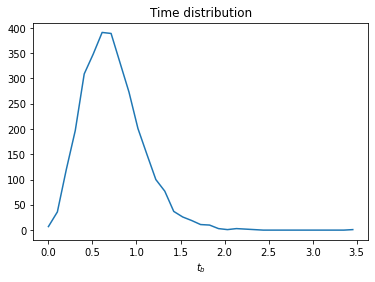

In [8]:
H=np.histogram(y, bins=35)
plt.plot(np.linspace(0, H[1][-1], H[0].size), H[0])
plt.title("Time distribution")
plt.xlabel("$t_b$")
plt.show()

In [9]:
t0= t.time()
for i in range(N):
    avg = 0
    if len(G[i]) == 0: continue
    for j in G[i]:
        e_idx = edgelist.index({i,j}) 
        if X[e_idx][0] == -1:
            X[e_idx][0], p1_prev, p1_for = cycle(i, j, "s")                                                 #finds left ring

            if X[e_idx][0] != 0:
                X[e_idx][1], p2_prev, p2_for =cycle(i, j, "d")                                            #finds right ring
                X[e_idx][2] = cycle(i, p2_prev, "f")[0] if len(G[i]) == 3 else 0
                X[e_idx][3] = cycle(j, p1_for, "f")[0] if len(G[j]) == 3 else 0
            else:
                X[e_idx][1:4] = np.zeros(3)

            X[e_idx][4:6] = np.array([len(G[i]), len(G[j])])
        avg += len(G[j])
        
    avg /= len(G[i])                                                             #finds 3
    
    for j in G[i]:
        idx= 7 if i>j else 6
        X[edgelist.index({i,j})][idx] = avg                                      #finds 4
        
print(t.time()-t0)

0.7831151485443115


In [10]:
def cleanx(x):
    return 16 if (x==0 or x>15) else x

X[:, 0:4]=[[cleanx(i) for i in x] for x in X[:, 0:4]]

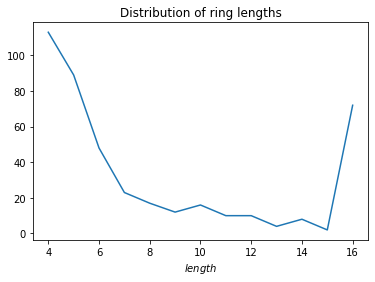

In [11]:
l,occ=np.unique(X[:,0], return_counts=True)
occ[1:]=occ[1:]/l[1:]
plt.plot(l, occ)
plt.title("Distribution of ring lengths")
plt.xlabel("$length$")
plt.show()

# Learning parameters

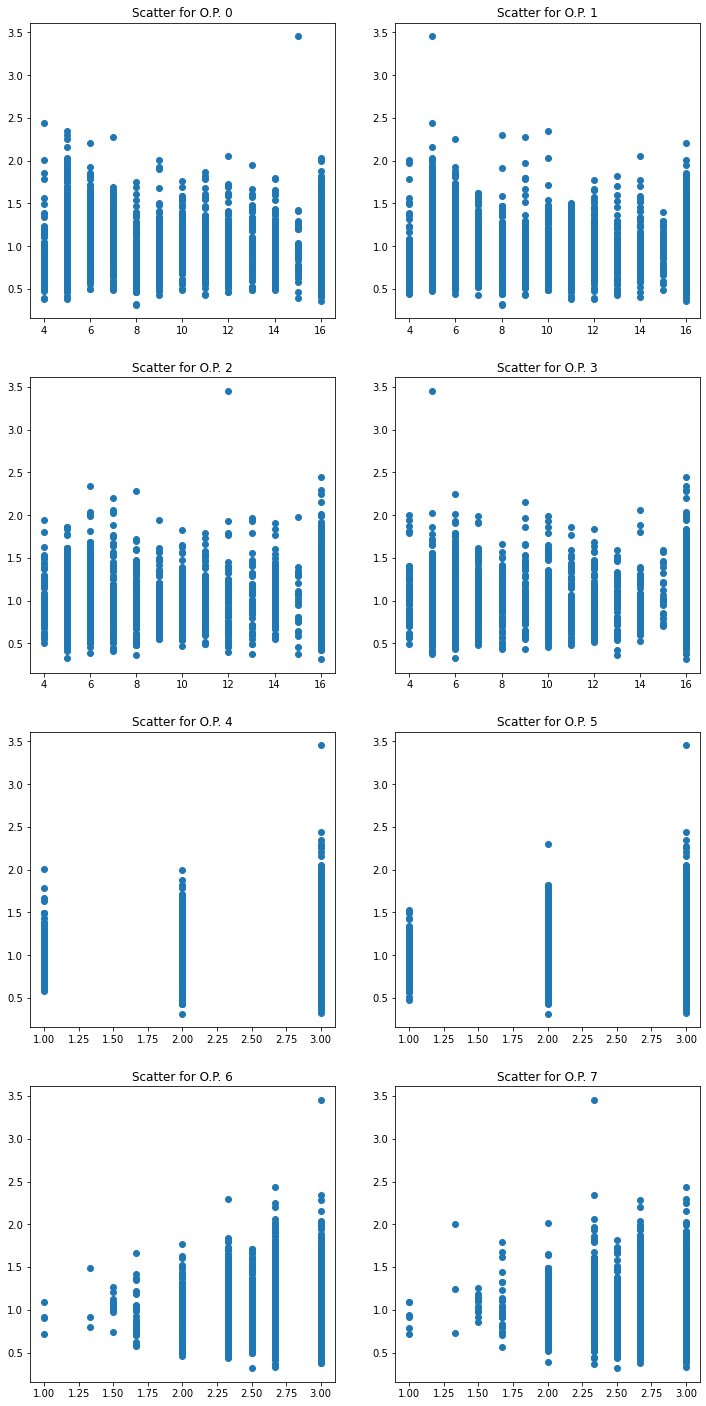

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(12,25))
for i in range(4):
    for j in range(2):
        axes[i][j].set_title("Scatter for O.P. %i"%(2*i+j))
        axes[i][j].scatter(X[:,2*i+j],y)
plt.show()

In [13]:
#Importing the relevant parts of pytorch
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

#This is for printing some progress
from IPython.display import clear_output
X=torch.from_numpy(X).float()
y=torch.from_numpy(y).float().unsqueeze(1)

In [35]:
def test_train_split(X, y, test_fraction, shuffle=True):
    d_size = len(X)
    indices = list(range(d_size))
    split = int(np.floor(test_fraction*d_size))
    if shuffle:
        np.random.seed(1)
        np.random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]
    return (X[train_indices], y[train_indices], X[test_indices], y[test_indices])

In [14]:
#Set a fixed seed, since we're testing things
torch.manual_seed(1)    # reproducible

In [41]:
X_train, y_train, X_test, y_test=test_train_split(X,y, .2)

3043 3043


In [43]:
#One way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(8, 12),
        torch.nn.Tanh(),
        torch.nn.Linear(12, 8),
        torch.nn.Tanh(),
        torch.nn.Linear(8, 1),
    )

#Optimizer: Adam
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) 

#Stochastic Gradient Descent is another option
#optimizer =  torch.optim.SGD(net.parameters(), lr = 0.05, momentum=0.9, weight_decay=1e-5)

loss_func = torch.nn.MSELoss()  # this is our loss function: mean squared error

In [72]:
# train the network
# You can run this cell multiple times, or just change the number of steps.
# I get decent results after ~10000 steps.
# Given the current size of the dataset, we may be overfitting...
for t in range(1000):
  
    prediction = net(X_train)     # input x and predict based on x

    loss = loss_func(prediction, y_train)     # must be (1. nn output, 2. target)

    #Print loss each cycle to keep track, after clearing the previous print statements
    clear_output(wait=True)
    print(t, loss.data.numpy())

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
# plot current status: prediction versus real value
tt = np.arange(0.5,2., 0.2)

999 0.06557187


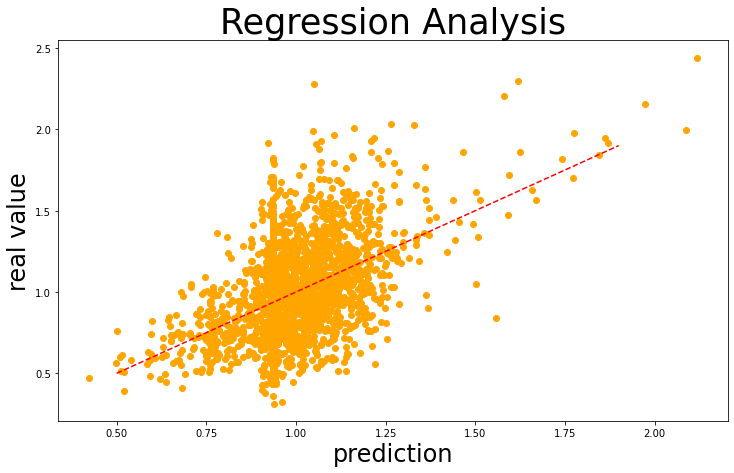

In [74]:
fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Regression Analysis', fontsize=35)
ax.set_xlabel('prediction', fontsize=24)
ax.set_ylabel('real value', fontsize=24)
plt.scatter(prediction.data.numpy(), y_train.data.numpy(), color = "orange")
# Dashed line is the ideal result
plt.plot(tt,tt,'r--')
plt.show()

In [75]:
net.eval()
def accuracy(model, X, y, pct_close):
    n=len(y)
    n_correct = torch.sum(torch.abs(model(X)-y)<torch.abs(pct_close*y))
    return n_correct.item()*100./n
    
acc=accuracy(net, X_test, y_test, .15)
print("Accuracy of %0.2f %%" % acc)

Accuracy of 38.32 %
